In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

file_path = "C:/Users/anita/Downloads/urn_mavedb_00000003-a-1_scores.csv" # Update with your dataset path
dataset = pd.read_csv(file_path)


columns_to_drop = ['hgvs_splice']  
dataset.drop(columns=[col for col in columns_to_drop if col in dataset.columns], inplace=True)
required_columns = ['hgvs_nt', 'hgvs_pro', 'score']
for col in required_columns:
    if col not in dataset.columns:
        raise ValueError(f"Required column '{col}' is missing.")
dataset.dropna(subset=required_columns, inplace=True)

# Parse and encode hgvs_nt and hgvs_pro
def parse_hgvs_nt(hgvs_nt):
    if pd.isna(hgvs_nt):
        return None
    try:
        mutations = hgvs_nt.strip("c.[]").split(";")
        return sum([int(m[:-3]) for m in mutations]) 
    except Exception:
        return None

def parse_hgvs_pro(hgvs_pro):
    if pd.isna(hgvs_pro):
        return None
    try:
        mutations = hgvs_pro.strip("p.[]").split(";")
        return sum([int("".join(filter(str.isdigit, m))) for m in mutations])
    except Exception:
        return None

dataset['encoded_hgvs_nt'] = dataset['hgvs_nt'].apply(parse_hgvs_nt)
dataset['encoded_hgvs_pro'] = dataset['hgvs_pro'].apply(parse_hgvs_pro)

# Drop rows with invalid parsed data
dataset.dropna(subset=['encoded_hgvs_nt', 'encoded_hgvs_pro'], inplace=True)

replicate_cols = [col for col in dataset.columns if col.startswith('score_PlusE2')]
if replicate_cols:
    dataset['mean_score'] = dataset[replicate_cols].mean(axis=1, skipna=True)
else:
    dataset['mean_score'] = dataset['score']

# Normalize numerical columns
numerical_cols = ['mean_score', 'SE', 'epsilon', 'encoded_hgvs_nt', 'encoded_hgvs_pro']
dataset[numerical_cols] = dataset[numerical_cols].apply(lambda x: (x - x.mean()) / x.std(), axis=0)


features = dataset[['encoded_hgvs_nt', 'encoded_hgvs_pro', 'SE', 'epsilon']].fillna(0)
target = dataset['mean_score']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")



Mean Squared Error: 0.9142513218557072
R² Score: 0.09847904398738783


Feature Importance:
            Feature  Importance
2                SE    0.488753
0   encoded_hgvs_nt    0.293425
1  encoded_hgvs_pro    0.183059
3           epsilon    0.034763


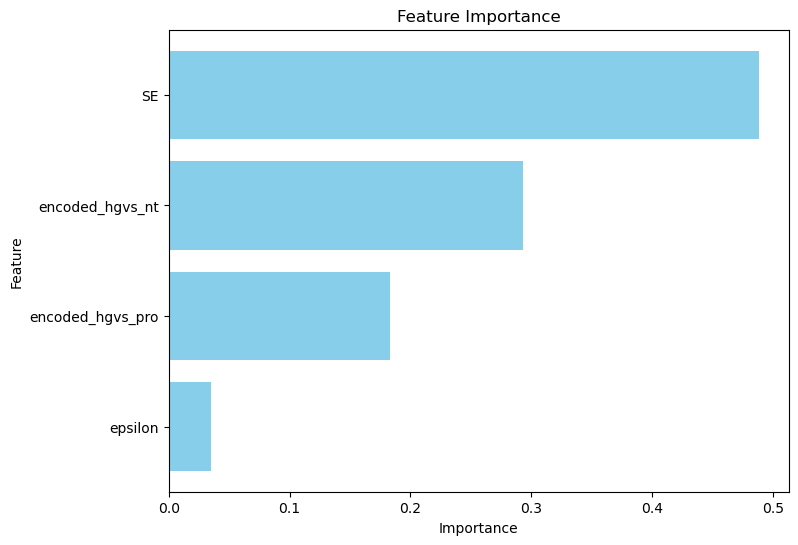

In [2]:
import matplotlib.pyplot as plt
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [3]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Extract the best model
best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {-grid_search.best_score_}")

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Test Set Mean Squared Error (Best Model): {mse_best}")
print(f"Test Set R² Score (Best Model): {r2_best}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best CV Score: 0.805653039386633
Test Set Mean Squared Error (Best Model): 0.824608047165375
Test Set R² Score (Best Model): 0.18687409332119054


Top Residues:
                           accession  mean_score
1          urn:mavedb:00000003-a-1#2    0.805832
9         urn:mavedb:00000003-a-1#10    1.060160
13        urn:mavedb:00000003-a-1#14    2.117338
19        urn:mavedb:00000003-a-1#20    1.144894
26        urn:mavedb:00000003-a-1#27    0.800349
...                              ...         ...
20669  urn:mavedb:00000003-a-1#20670    0.816326
20690  urn:mavedb:00000003-a-1#20691    0.920828
20698  urn:mavedb:00000003-a-1#20699    1.683244
20701  urn:mavedb:00000003-a-1#20702    1.112626
20712  urn:mavedb:00000003-a-1#20713    1.479202

[2032 rows x 2 columns]


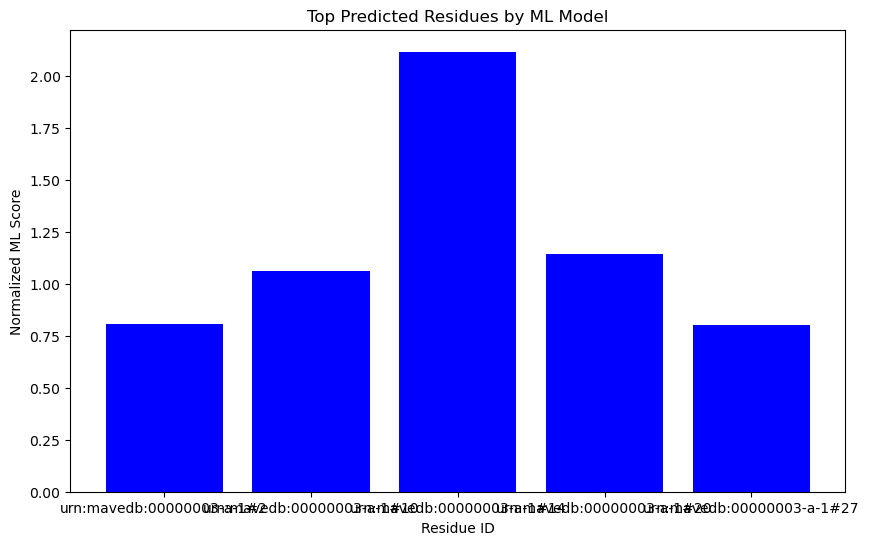

In [9]:
import matplotlib.pyplot as plt
threshold = 0.8# Adjust as needed
top_residues = dataset[dataset['mean_score'] > threshold]
print(f"Top Residues:\n{top_residues[['accession', 'mean_score']]}")
plt.figure(figsize=(10, 6))
plt.bar(top_residues['accession'][:5], top_residues['mean_score'][:5], color='blue')
plt.xlabel('Residue ID')
plt.ylabel('Normalized ML Score')
plt.title('Top Predicted Residues by ML Model')
plt.show()
